# header

In [1]:
'''
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

setInterval(ConnectButton,60000);
'''

# from google.colab import drive
# from os import chdir

# drive.mount('/content/drive')
# project_path = '/content/drive/MyDrive/Gproject/MIT_glyco'
# chdir(project_path)

'\nfunction ConnectButton(){\n    console.log("Connect pushed"); \n    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() \n}\n\nsetInterval(ConnectButton,60000);\n'

In [2]:
import pandas as pd
import numpy as np

import os
from os.path import exists
print(os.getcwd()) # current working directory

update = False

D:\Gdrive\My Drive\Gproject\MIT_glyco


In [3]:
load_name = "./data/data_for_ml.csv"
protein_list = list(pd.read_csv(load_name).protein.unique())
protein_augmented = [name for name in protein_list if exists(f'./data/data_for_ml(augmented)/{name}.csv')]

dataset = []
for name in protein_augmented:
    load_path = f'./data/data_for_ml(augmented)/{name}.csv'
    dataset.append(pd.read_csv(load_path))
dataset = pd.concat(dataset, axis=0).reset_index(drop=True)
dataset = dataset[(dataset['SEQ']=='S') | (dataset['SEQ']=='T')].reset_index(drop=True)

positive = dataset[dataset['positivity']==1]
negative = dataset[dataset['positivity']==0]

print("total number of proteins:          ", len(protein_list))
print("total number of augmented proteins:", len(protein_augmented))
print("total number of positive sites:    ", len(positive))

total number of proteins:           272
total number of augmented proteins: 89
total number of positive sites:     185


## parameter settings

In [4]:
from src.Data import xy_variables, df_to_dummy, stratified_split, up_sampling
from src.models import *

variables = xy_variables()
test_size = 0.2
valid_size = test_size/(1-test_size)

import random
random_state = 1
n_cv = 10

hpo_counts = 30
hpo_config = {
    "n_layers" : range(1,11),
    "n_neurons" : [16, 32, 64, 128, 256]
}
metrics = ['n_layers', 'n_neurons', 'epoch', 'time', 'loss', 'val_loss', 'test_loss', 'accuracy', 'precision', 'recall', 'f1']
method = "random"

# model

In [5]:
model_name = 'augmented_mlp_basic'
x_charge = pd.read_csv('./data/from_Krishna/features-all-names.csv').name.to_list()[:-1]

x_cts   = variables.x_cts_original + x_charge
x_cat   = variables.x_cat_original
y_label = variables.y_label

print(f"{len(x_cts)} x_cts:")
print(f"{len(x_cat)} x_cat: {x_cat}")
print(f"{len(y_label)} y_label: {y_label}")

data_x, data_y = df_to_dummy(dataset, x_cts, x_cat, y_label)
display(dict(zip(range(len(data_x.columns)), data_x.columns)))

168 x_cts:
2 x_cat: ['SEQ', 'SS']
1 y_label: ['positivity']
dummy x shape: (8910, 173)
dummy y shape: (8910, 1)


{0: 'ASA',
 1: 'Phi',
 2: 'Psi',
 3: 'Theta(i-1=>i+1)',
 4: 'Tau(i-2=>i+2)',
 5: 'HSE_alpha_up',
 6: 'HSE_alpha_down',
 7: 'P(C)',
 8: 'P(H)',
 9: 'P(E)',
 10: 'flexibility',
 11: '#',
 12: 'residue_SER_THR',
 13: 'number_of_hydrophobic',
 14: 'number_of_hydrophilic',
 15: 'number_of_polar',
 16: 'number_of_aromatic',
 17: 'number_of_aliphatic',
 18: 'number_of_charged',
 19: 'number_of_positive',
 20: 'number_of_negative',
 21: 'number_of_g',
 22: 'number_of_v',
 23: 'number_of_s',
 24: 'number_of_n',
 25: 'number_of_l',
 26: 'number_of_p',
 27: 'number_of_A',
 28: 'number_of_b',
 29: 'number_of_d',
 30: 'number_of_e',
 31: 'number_of_f',
 32: 'number_of_ala',
 33: 'number_of_cys',
 34: 'number_of_asp',
 35: 'number_of_glu',
 36: 'number_of_phe',
 37: 'number_of_his',
 38: 'number_of_ile',
 39: 'number_of_lys',
 40: 'number_of_leu',
 41: 'number_of_met',
 42: 'number_of_asn',
 43: 'number_of_gln',
 44: 'number_of_arg',
 45: 'number_of_ser',
 46: 'number_of_thr',
 47: 'number_of_val',


## cross validation

In [6]:
# select n_layers and n_neurons as the best values of HPO
n_layers = 5
n_neurons = 100
cv_path = f'./result/cv_result_{model_name}_{n_layers}_{n_neurons}_{n_cv}.csv'

cv_result = pd.DataFrame([], columns=metrics)
if not exists(cv_path) or update:
    for i in range(n_cv):
        print(f"\n{i+1}th iteration")
        random.seed(i+1)
        train_x, train_y, test_x, test_y, _, _ = stratified_split(data_x, data_y, 
                                                              test_size=test_size, random_state=i+1, 
                                                              scale_x=x_cts, scale_y=[])
        train_x, train_y = up_sampling(train_x, train_y)

        x_dim = train_x.shape[1]
        y_dim = train_y.shape[1]
        save_path  = f'./h5/{model_name}_{n_layers}_{n_neurons}_cv_{i+1}of{n_cv}.h5'

        model = MLP(x_dim, y_dim)
        model.build(n_layers, n_neurons)
        if not exists(save_path) or update:
            model.train(train_x, train_y, valid_size, save_path=save_path)
        else:
            model.load_model(save_path)

        epoch = model.epoch
        time = model.time
        loss = model.loss
        val_loss = model.val_loss
        test_loss, accuracy, precision, recall, f1 = model.evaluate(test_x, test_y)
        cv = pd.DataFrame([[n_layers, n_neurons, epoch, time, loss, val_loss, test_loss, accuracy, 
                             precision[1], recall[1], f1[1]]], columns=metrics)
        cv_result = pd.concat([cv_result, cv], axis=0)
    cv_result = cv_result.reset_index(drop=True)
    cv_result.to_csv(cv_path, index=False)    
    
else:
    cv_result = pd.read_csv(cv_path)

display(cv_result)


1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 173) (7128, 1)
check scale: 0.0 1.0

test: (1782, 173) (1782, 1)
check scale: -0.04063701263042285 1.1368831455094939
up-sampled train dataset: (13960, 173) (13960, 1)
MLP model has been saved to ./h5/augmented_mlp_basic_5_100_cv_1of10.h5

2th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 173) (7128, 1)
check scale: 0.0 1.0

test: (1782, 173) (1782, 1)
check scale: -0.053209459459459374 1.4285714285714286
up-sampled train dataset: (13960, 173) (13960, 1)
MLP model has been saved to ./h5/augmented_mlp_basic_5_100_cv_2of10.h5

3th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 173) (7128, 1)
check scale: 0.0 1.0

test: (1782, 173) (1782, 1)
check scale: -0.010150622134905045 1.1428571428571428
up-sampled train dataset: (13960, 173) (13960, 1)
MLP model has been saved to ./h5/augmented_mlp_basic_5_100_cv_3of10.h5

4th iteration
train/test dataset: <class 'numpy.ndarray'>


,n_layers,n_neurons,epoch,time,loss,val_loss,test_loss,accuracy,precision,recall,f1
0,5,100,113,1.678,0.566488,0.566277,0.575943,66.44,4.09,67.57,7.72
1,5,100,105,1.563,0.548877,0.542416,0.528312,71.04,4.38,62.16,8.19
2,5,100,69,1.159,0.569229,0.565267,0.580642,67.45,4.06,64.86,7.64
3,5,100,108,1.552,0.550908,0.544310,0.554976,69.53,3.66,54.05,6.86
4,5,100,102,1.498,0.557712,0.563029,0.586551,66.05,3.90,64.86,7.35
5,5,100,148,1.987,0.561615,0.556683,0.579544,67.96,4.59,72.97,8.64
6,5,100,58,0.981,0.550488,0.547154,0.548295,70.15,4.25,62.16,7.96
7,5,100,214,2.690,0.532273,0.533697,0.515388,72.05,3.05,40.54,5.68
8,5,100,263,2.628,0.569790,0.573923,0.542828,70.43,4.96,72.97,9.29
9,5,100,24,0.520,0.563996,0.560728,0.601005,67.56,3.44,54.05,6.47



1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 173) (7128, 1)
check scale: 0.0 1.0

test: (1782, 173) (1782, 1)
check scale: -0.04063701263042285 1.1368831455094939
up-sampled train dataset: (13960, 173) (13960, 1)
MLP model has been restored from ./h5/augmented_mlp_basic_5_100_cv_1of10.h5


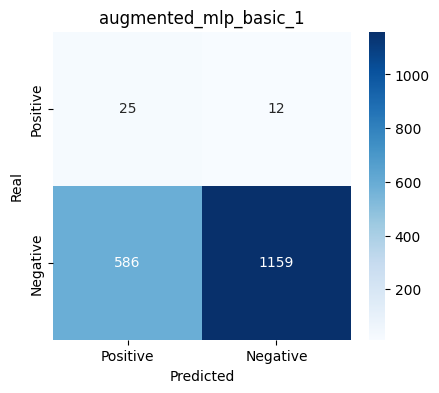

accuracy  : 66.44
precision : [98.98  4.09]
recall    : [66.42 67.57]
f1_score  : [79.49  7.72]

2th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 173) (7128, 1)
check scale: 0.0 1.0

test: (1782, 173) (1782, 1)
check scale: -0.053209459459459374 1.4285714285714286
up-sampled train dataset: (13960, 173) (13960, 1)
MLP model has been restored from ./h5/augmented_mlp_basic_5_100_cv_2of10.h5


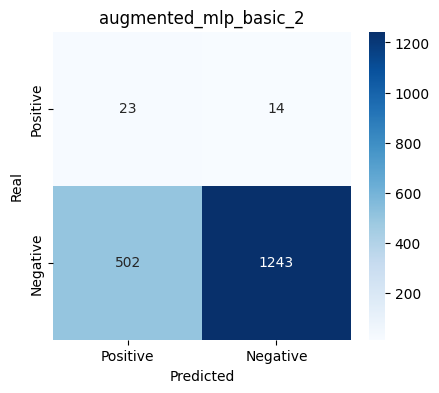

accuracy  : 71.04
precision : [98.89  4.38]
recall    : [71.23 62.16]
f1_score  : [82.81  8.19]

3th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 173) (7128, 1)
check scale: 0.0 1.0

test: (1782, 173) (1782, 1)
check scale: -0.010150622134905045 1.1428571428571428
up-sampled train dataset: (13960, 173) (13960, 1)
MLP model has been restored from ./h5/augmented_mlp_basic_5_100_cv_3of10.h5


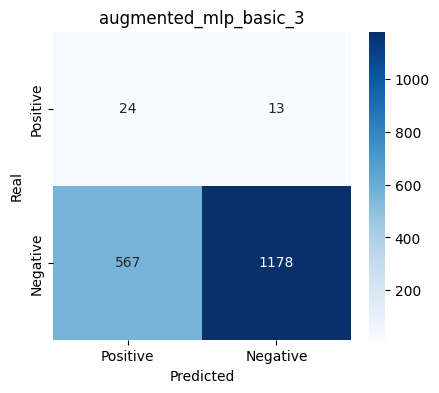

accuracy  : 67.45
precision : [98.91  4.06]
recall    : [67.51 64.86]
f1_score  : [80.25  7.64]

4th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 173) (7128, 1)
check scale: 0.0 1.0

test: (1782, 173) (1782, 1)
check scale: -0.04063701263042285 1.3335864392504608
up-sampled train dataset: (13960, 173) (13960, 1)
MLP model has been restored from ./h5/augmented_mlp_basic_5_100_cv_4of10.h5


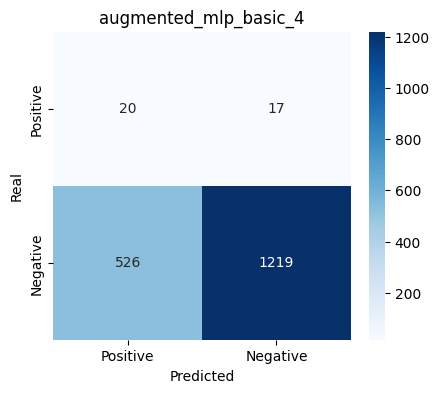

accuracy  : 69.53
precision : [98.62  3.66]
recall    : [69.86 54.05]
f1_score  : [81.78  6.86]

5th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 173) (7128, 1)
check scale: 0.0 1.0

test: (1782, 173) (1782, 1)
check scale: -0.05361702127659566 1.2857142857142858
up-sampled train dataset: (13960, 173) (13960, 1)
MLP model has been restored from ./h5/augmented_mlp_basic_5_100_cv_5of10.h5


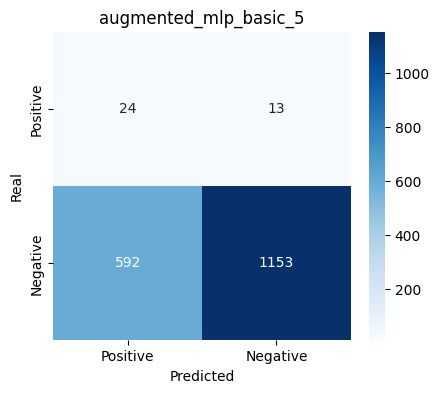

accuracy  : 66.05
precision : [98.89  3.9 ]
recall    : [66.07 64.86]
f1_score  : [79.22  7.35]

6th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 173) (7128, 1)
check scale: 0.0 1.0

test: (1782, 173) (1782, 1)
check scale: -0.03435948361469706 1.4285714285714286
up-sampled train dataset: (13960, 173) (13960, 1)
MLP model has been restored from ./h5/augmented_mlp_basic_5_100_cv_6of10.h5


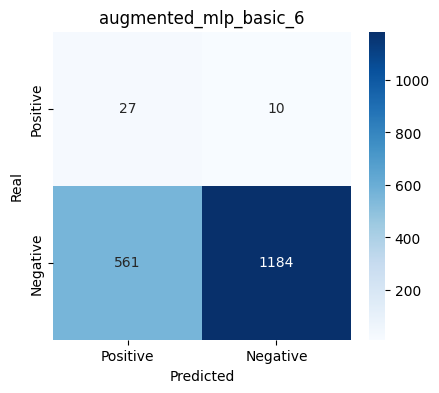

accuracy  : 67.96
precision : [99.16  4.59]
recall    : [67.85 72.97]
f1_score  : [80.57  8.64]

7th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 173) (7128, 1)
check scale: 0.0 1.0

test: (1782, 173) (1782, 1)
check scale: -0.08261159227181879 1.5714285714285714
up-sampled train dataset: (13960, 173) (13960, 1)
MLP model has been restored from ./h5/augmented_mlp_basic_5_100_cv_7of10.h5


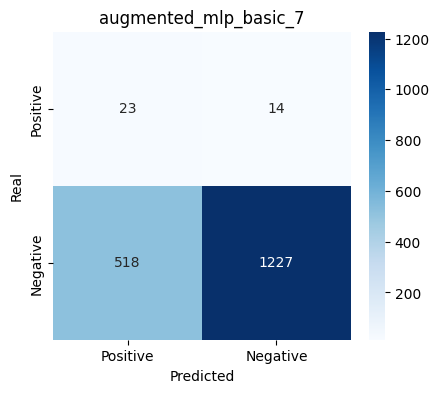

accuracy  : 70.15
precision : [98.87  4.25]
recall    : [70.32 62.16]
f1_score  : [82.18  7.96]

8th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 173) (7128, 1)
check scale: 0.0 1.0

test: (1782, 173) (1782, 1)
check scale: -0.07051046204631907 1.375
up-sampled train dataset: (13960, 173) (13960, 1)
MLP model has been restored from ./h5/augmented_mlp_basic_5_100_cv_8of10.h5


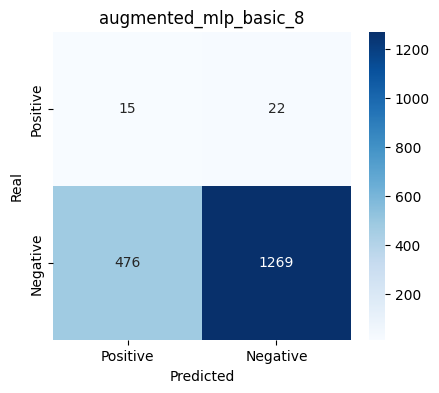

accuracy  : 72.05
precision : [98.3   3.05]
recall    : [72.72 40.54]
f1_score  : [83.6   5.68]

9th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 173) (7128, 1)
check scale: 0.0 1.0

test: (1782, 173) (1782, 1)
check scale: -0.042349728369226396 1.1875
up-sampled train dataset: (13960, 173) (13960, 1)
MLP model has been restored from ./h5/augmented_mlp_basic_5_100_cv_9of10.h5


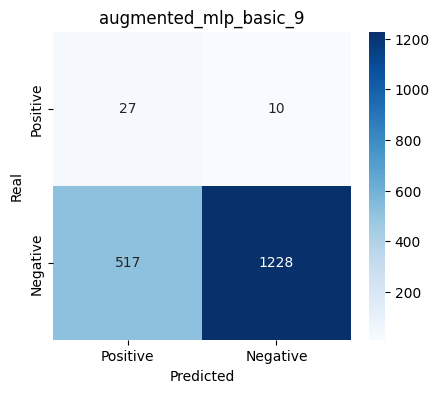

accuracy  : 70.43
precision : [99.19  4.96]
recall    : [70.37 72.97]
f1_score  : [82.33  9.29]

10th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 173) (7128, 1)
check scale: 0.0 1.0

test: (1782, 173) (1782, 1)
check scale: -0.08623693379790943 1.375
up-sampled train dataset: (13960, 173) (13960, 1)
MLP model has been restored from ./h5/augmented_mlp_basic_5_100_cv_10of10.h5


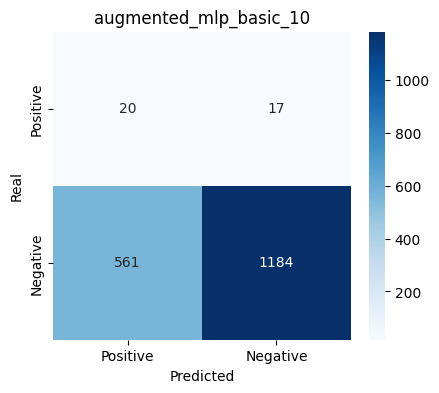

accuracy  : 67.56
precision : [98.58  3.44]
recall    : [67.85 54.05]
f1_score  : [80.38  6.47]


In [7]:
from src.graph_plot import *

for i in range(n_cv):
    print(f"\n{i+1}th iteration")
    random.seed(i+1)
    train_x, train_y, test_x, test_y, _, _ = stratified_split(data_x, data_y, 
                                                          test_size=test_size, random_state=i+1, 
                                                          scale_x=x_cts, scale_y=[])
    train_x, train_y = up_sampling(train_x, train_y)

    x_dim = train_x.shape[1]
    y_dim = train_y.shape[1]
    save_path  = f'./h5/{model_name}_{n_layers}_{n_neurons}_cv_{i+1}of{n_cv}.h5'

    model = MLP(x_dim, y_dim)
    model.build(n_layers, n_neurons)
    model.load_model(save_path)
    
    prediction = model.model.predict(test_x, verbose=0)
    y_pred = prediction.round(0).astype(int)
    y_real = test_y
    
    plot_confusion(y_real, y_pred, title=model_name+f"_{i+1}", label=["Positive","Negative"])